In [1]:
import parametrization as param
from CentralStreamingModel.utils.read_probabilities import VD, VD_los
from CentralStreamingModel.projection import generating_moments
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d, interp2d
import seaborn as sns
from CentralStreamingModel.moments import moments2model, read
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
import taylor_tools as tt
import spline_taylor_tools as stt
import math
sns.set_context('talk')

In [2]:
n_boxes = 5
boxsize = 1024
snapshot = 0
rm = read.Read_Mean(n_boxes, boxsize, snapshot)

/cosma6/data/dp004/dc-cues1/pv_results/halos_b1.txt
/cosma6/data/dp004/dc-cues1/pv_results/halos_b2.txt
/cosma6/data/dp004/dc-cues1/pv_results/halos_b3.txt
/cosma6/data/dp004/dc-cues1/pv_results/halos_b4.txt
/cosma6/data/dp004/dc-cues1/pv_results/halos_b5.txt


In [3]:
parameters = [r'$m_r$',r'$c_r$',r'$c_t$',r'$\xi$']

In [4]:
ex = generating_moments.Expectations(rm.r, rm.v_r, rm.v_t,
                                     rm.jointpdf_rt)

In [5]:
gaussian = moments2model.Model(rm, ex, model='gaussian')


In [81]:
m_r = ex.moment(1,0)(rm.r)
c_r = ex.central_moment(2,0)(rm.r)
c_t = ex.central_moment(0,2)(rm.r)
c_3r = ex.central_moment(3, 0)(rm.r)
c_3t = ex.central_moment(1, 2)(rm.r)

c_4r = ex.central_moment(4, 0)(rm.r)

c_4t = ex.central_moment(0, 4)(rm.r)


## Contributions to higher order moments for mu =1

Text(0.5,0,'r [Mpc/h]')

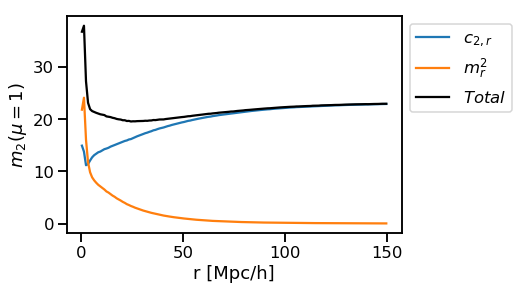

In [7]:
# Terms that enter m2 FoG (mu = 1)

plt.plot(rm.r, c_r, label = '$c_{2, r}$') 
plt.plot(rm.r,  m_r**2, label = '$m_r^2$')

plt.plot(rm.r, c_r + m_r**2, 
         label = '$Total$', color = 'black')

plt.legend(bbox_to_anchor= (1,1))
plt.ylabel('$m_2 (\mu = 1)$')
plt.xlabel('r [Mpc/h]')

Text(0.5,0,'r [Mpc/h]')

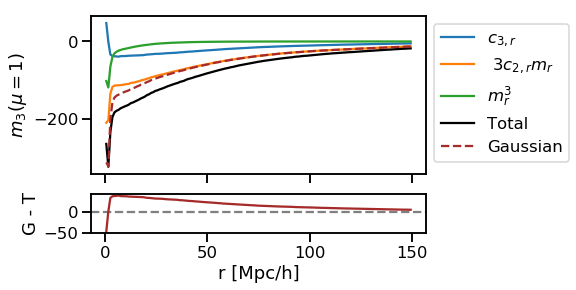

In [8]:
m3_gaussian =  3. * (c_r * m_r)  +  m_r**3
m3 = c_3r + 3. * (c_r * m_r)  +  m_r**3

fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(rm.r, c_3r, label = '$c_{3, r}$') 
ax1.plot(rm.r, 3. * (c_r * m_r), label = ' $3  c_{2, r} m_r $ ')
ax1.plot(rm.r, m_r**3, label = '$ m_r ^3 $')

ax1.plot(rm.r, m3, 
         label = 'Total', color = 'black')
ax1.plot(rm.r, m3_gaussian,
         label = 'Gaussian', color = 'brown', linestyle = 'dashed')

ax1.legend(bbox_to_anchor=(1,1))
ax1.set_ylabel('$m_3 (\mu = 1)$')

ax2.axhline(y = 0., linestyle='dashed', color = 'gray')
ax2.plot(rm.r, m3_gaussian-m3, color = 'brown' )
ax2.set_ylabel('G - T')
ax2.set_xlabel('r [Mpc/h]')

(0, 50)

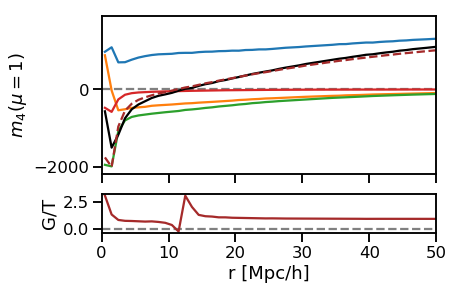

In [9]:
m4_gaussian =  3 * c_r**2 - 6.* (c_r * m_r**2) -1. * ( m_r**4)
m4 = c_4r -4. *(c_3r * m_r) -6.* (c_r * m_r**2) -1.* ( m_r**4)

fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.axhline(y = 0., color = 'gray', linestyle='dashed')


ax1.plot(rm.r, c_4r, label = '$c_{4, r}$') 
ax1.plot(rm.r, -4. * (c_3r * m_r), label = ' $-4  c_{3, r} m_r $ ')
ax1.plot(rm.r, -6. * (c_r * m_r**2), label = ' $-6  c_{2, r} m_r^2 $ ')
ax1.plot(rm.r, -1. * ( m_r**4), label = ' $-m_r^4 $ ')

ax1.plot(rm.r, c_4r -4. *(c_3r * m_r) -6.* (c_r * m_r**2) -1.* ( m_r**4), 
         label = 'total', color = 'black')

ax1.plot(rm.r, 3 * c_r**2 - 6.* (c_r * m_r**2) -1. * ( m_r**4),
         label = 'Gaussian', linestyle='dashed', color = 'brown')

#ax1.legend(bbox_to_anchor = (1.,1.))
ax1.set_ylabel('$m_4 (\mu = 1)$')

ax2.axhline(y = 0., linestyle='dashed', color = 'gray')
ax2.plot(rm.r, m4_gaussian/m4, color = 'brown' )
ax2.set_ylabel('G/T')
ax2.set_xlabel('r [Mpc/h]')

ax1.set_xlim(0,50)
ax2.set_xlim(0,50)

## Check projection to line of sigh

## Mean

In [29]:
s = np.sqrt(rm.r_perp.reshape(-1, 1)**2 + rm.r_parallel.reshape(1, -1)**2)

mu = rm.r_parallel/s

measured_m1 = simps(rm.v_los * rm.jointpdf_los, rm.v_los, axis = -1) 


#gamma1 = simps( (rm.v_los - mean[..., np.newaxis])**3 * rm.jointpdf_los, rm.v_los, axis = -1)/std**3

#gamma2 = simps( (rm.v_los - mean[..., np.newaxis])**4 * rm.jointpdf_los, rm.v_los, axis = -1)/std**4 - 3.


In [30]:
def m1(s, mu, m1_r, args = ()):
    
    return mu * m1_r(s, *args)


In [42]:


projected_m1 = m1(s, mu, ex.moment(1,0))


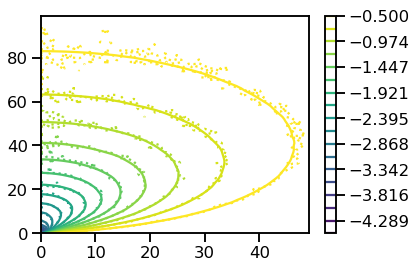

In [32]:
levels = np.linspace(-5., -0.5, 20)

plt.contour(measured_m1.T, levels = levels,
           linestyles = 'dotted')

plt.contour(projected_m1.T, levels = levels)
plt.colorbar()

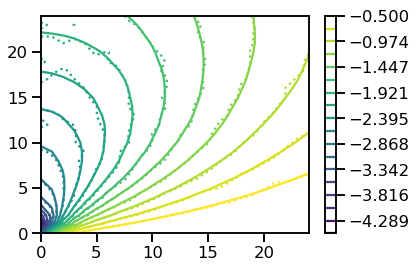

In [33]:
plt.contour(measured_m1.T[:25,:25], levels = levels,
           linestyles = 'dotted')

plt.contour(projected_m1.T[:25,:25], levels = levels)
plt.colorbar()

In [34]:
def fitting_m1_r(r, a,c,d):
    return a * r**(0.5) + c*r + d 

popt_m_r, pcov_m_r = curve_fit(fitting_m1_r, rm.r, m_r)

Text(0.5,0,'r [Mpc/h]')

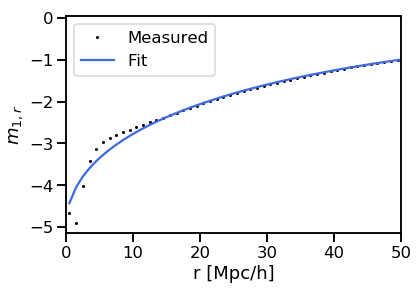

In [38]:
plt.plot(rm.r, m_r, linestyle = '',
        marker = 'o', markersize= 2, 
         color = 'black', label = 'Measured')
plt.plot(rm.r, fitting_m1_r(rm.r, *popt_m_r), 
         label = 'Fit', color = 'royalblue')
plt.xlim(0,50)
plt.legend()
plt.ylabel(r'$m_{1,r}$')
plt.xlabel(r'r [Mpc/h]')

In [40]:
# Compare fitted projection to measured

projected_fit_m1 = m1(s, mu, fitting_m1_r, args = (popt_m_r))


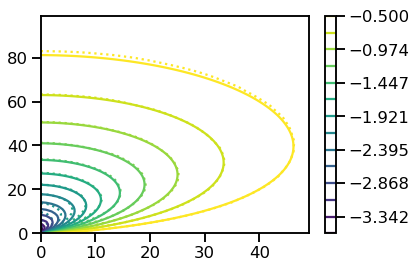

In [43]:
levels = np.linspace(-5., -0.5, 20)

plt.contour(projected_m1.T, levels = levels,
           linestyles = 'dotted')

plt.contour(projected_fit_m1.T, levels = levels)
plt.colorbar()

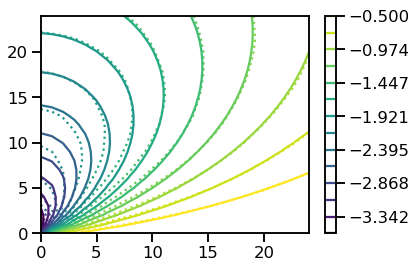

In [44]:
levels = np.linspace(-5., -0.5, 20)

plt.contour(projected_m1[:25,:25].T, levels = levels,
           linestyles = 'dotted')

plt.contour(projected_fit_m1[:25,:25].T, levels = levels)
plt.colorbar()

## Second central moment c_2

In [45]:
measured_c2 = simps( (rm.v_los )**2 * rm.jointpdf_los, rm.v_los, axis = -1)

def c2(s, mu, c2_r, c2_t, args_r = (), args_t = ()):
    
    return mu ** 2 * c2_r(s, *args_r) + (1 - mu**2) * c2_t(s, *args_t) 

In [46]:
projected_c2 = c2(s, mu, ex.moment(2,0), ex.moment(0,2))


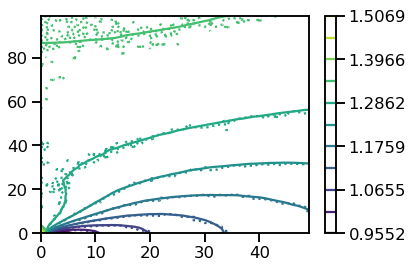

In [55]:
levels = np.linspace(0.9, 2.5, 30)

plt.contour(np.log10(measured_c2).T, levels = levels,
           linestyles = 'dotted')

plt.contour(np.log10(projected_c2).T, levels = levels)
plt.colorbar()

In [57]:
def fitting_c2(r, a, b,c):

    return a * r**b  + c

popt_c_r, pcov_c_r = curve_fit(fitting_c2, rm.r, c_r)

popt_c_t, pcov_c_t = curve_fit(fitting_c2, rm.r, c_t)

Text(0.5,0,'r [Mpc/h]')

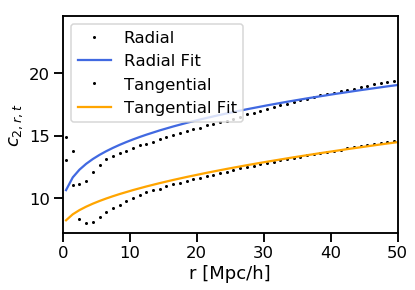

In [62]:
plt.plot(rm.r, c_r, linestyle = '',
        marker = 'o', markersize= 2, 
         color = 'black', label = 'Radial')
plt.plot(rm.r, fitting_c2(rm.r, *popt_c_r), 
         label = 'Radial Fit', color = 'royalblue')

plt.plot(rm.r, c_t, linestyle = '',
        marker = 'o', markersize= 2, 
         color = 'black', label = 'Tangential')
plt.plot(rm.r, fitting_c2(rm.r, *popt_c_t), 
         label = 'Tangential Fit', color = 'orange')
plt.xlim(0,50)
plt.legend()
plt.ylabel(r'$c_{2,r,t}$')
plt.xlabel(r'r [Mpc/h]')

In [63]:

projected_fit_c2 = c2(s, mu, fitting_c2, fitting_c2, args_r = (popt_c_r), args_t = (popt_c_t))


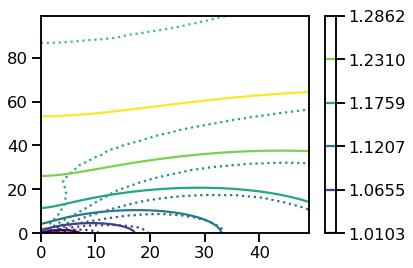

In [65]:
levels = np.linspace(0.9, 2.5, 30)

plt.contour(np.log10(projected_c2).T, levels = levels,
           linestyles = 'dotted')

plt.contour(np.log10(projected_fit_c2).T, levels = levels)
plt.colorbar()

In [66]:
# Very bad fit, should be improved

## Third moment c3

In [67]:
measured_c3 = simps( (rm.v_los )**3 * rm.jointpdf_los, rm.v_los, axis = -1)

# c3_t is really 2t, 1r correlation
def c3(s, mu, c3_r, c3_t, args_r = (), args_t = ()):
    
    return mu ** 3 * c3_r(s, *args_r) + 3 * mu * (1 - mu**2) * c3_t(s, *args_t) 

In [68]:
projected_c3 = c3(s, mu, ex.moment(3,0), ex.moment(1,2))


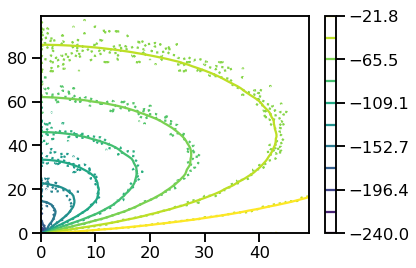

In [76]:
levels = np.linspace(-240, 0, 12)
plt.contour((measured_c3).T, levels = levels,
           linestyles = 'dotted')

plt.contour((projected_c3).T, levels = levels)
plt.colorbar()

In [77]:
def fitting_c3(r, a, b,c):

    return a/r + b*np.log(r) + c 

In [82]:
popt_c3_r, pcov_c3_r = curve_fit(fitting_c3, rm.r, c_3r)

popt_c3_t, pcov_c3_t = curve_fit(fitting_c3, rm.r, c_3t)


Text(0.5,0,'r [Mpc/h]')

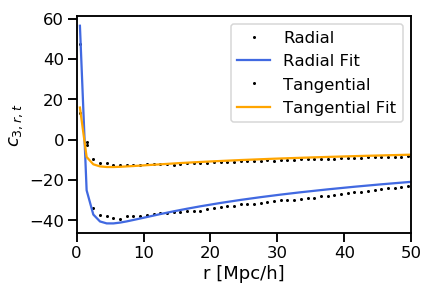

In [85]:
plt.plot(rm.r, c_3r, linestyle = '',
        marker = 'o', markersize= 2, 
         color = 'black', label = 'Radial')
plt.plot(rm.r, fitting_c3(rm.r, *popt_c3_r), 
         label = 'Radial Fit', color = 'royalblue')

plt.plot(rm.r, c_3t, linestyle = '',
        marker = 'o', markersize= 2, 
         color = 'black', label = 'Tangential')
plt.plot(rm.r, fitting_c3(rm.r, *popt_c3_t), 
         label = 'Tangential Fit', color = 'orange')
plt.xlim(0,50)
plt.legend()
plt.ylabel(r'$c_{3,r,t}$')
plt.xlabel(r'r [Mpc/h]')

In [100]:
projected_fit_c3 = c3(s, mu, ex.moment(3,0), fitting_c3, args_t = (popt_c3_t))
                     # args_r = (popt_c3_r))#, args_t = (popt_c3_t))


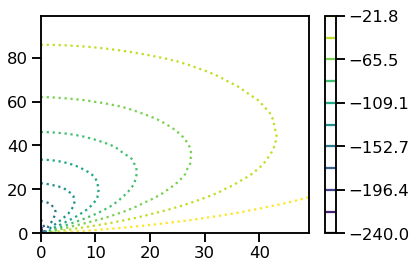

In [101]:
plt.contour((projected_c3).T, levels = levels,
           linestyles = 'dotted')
plt.colorbar()

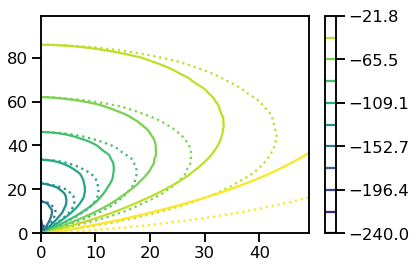

In [102]:
plt.contour((projected_c3).T, levels = levels,
           linestyles = 'dotted')

plt.contour((projected_fit_c3).T, levels = levels)
plt.colorbar()

## Two point correlation function

In [109]:
threshold = (rm.tpcf_dict['r'] > 5) & (rm.tpcf_dict['r'] < 60)

r_spl_xi = np.linspace(np.min(rm.tpcf_dict['r'][threshold]), 
                       np.max(rm.tpcf_dict['r'][threshold]), 
                       500)


xi_spl = UnivariateSpline(rm.tpcf_dict['r'][threshold],
            rm.tpcf_dict['tpcf'][threshold], k = 2, s = 0.005)

## Compute directly first derivatives (Right now not using fitting formula!)

In [110]:

def derivative(f, a, n = 1, args = (), h = 0.0001):

    if n == 1:
        return (f(a + h, *args) - f(a - h, *args))/(2*h)
    
    elif n == 2:
        return (f(a + h, *args) - 2 * f(a, *args) + f(a - h, *args))/h**2
    
    elif n == 3:
        return (- 0.5 * f(a - 2* h , *args) + f(a - h, *args) - f(a + h, *args) + 0.5 *f(a + 2*h, *args)  )/h**3

    else:
        raise ValueError("Too high order, not implemented.")

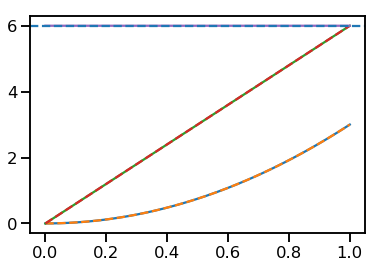

In [111]:
def f(x): 
    return x **3
    
x_test = np.linspace(0.,1.,100)

der = derivative(f, x_test)
der_2 = derivative(f, x_test, n = 2)
der_3 = derivative(f, x_test, n = 3)

plt.plot(x_test, der)
plt.plot(x_test, 3 * x_test **2, linestyle = 'dashed')
plt.plot(x_test, der_2)
plt.plot(x_test, 6 * x_test, linestyle='dashed')
plt.plot(x_test, der_3)
plt.axhline(y = 6, linestyle='dashed')

In [112]:
def m1_pi_sigma(sparal, sperp, popt_m_r):
    
    s = np.sqrt(sperp.reshape(-1, 1)**2 + sparal.reshape(1, -1)**2)
    mu = sparal / s
    
    return m1(s, mu, fitting_m1_r, args = (popt_m_r))

In [113]:
def first_order(sperp, sparal, xi_spl, popt_m_r):

    s = np.sqrt(sperp.reshape(-1, 1)**2 + sparal.reshape(1, -1)**2)

    return xi_spl(s) - derivative(m1_pi_sigma, sperp, args = (sperp, popt_m_r) )

In [114]:
fo = first_order(rm.s_c, rm.s_c, xi_spl, popt_m_r)


Text(0,0.5,'$s_\\parallel$')

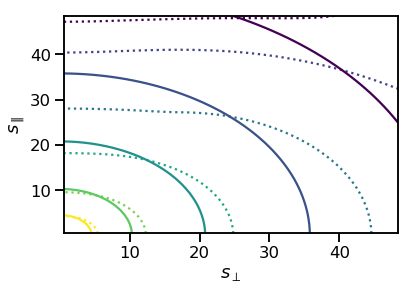

In [135]:
levels = np.linspace(-4. ,1., 10)


plt.contour(rm.s_c, rm.s_c, np.log10(fo).T,
            levels = levels, linestyles = 'dotted')



plt.contour(rm.s_c, rm.s_c, np.log10(xi_spl(np.sqrt(rm.s_c.reshape(-1, 1)**2 + rm.s_c.reshape(1, -1)**2))),
           levels = levels)

plt.xlabel(r'$s_\perp$')
plt.ylabel(r'$s_\parallel$')

Text(0,0.5,'$s_\\parallel$')

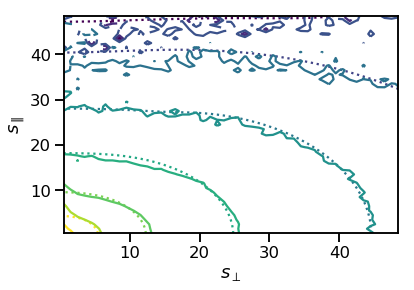

In [115]:
levels = np.linspace(-4. ,1., 10)


plt.contour(rm.s_c, rm.s_c, np.log10(fo).T,
            levels = levels, linestyles = 'dotted')



plt.contour(rm.s_c, rm.s_c, np.log10(rm.pi_sigma.mean.T),
           levels = levels)

plt.xlabel(r'$s_\perp$')
plt.ylabel(r'$s_\parallel$')

In [119]:
def m2_pi_sigma(sparal, sperp, popt_m_r, popt_c_r, popt_c_t):
    
    s = np.sqrt(sperp.reshape(-1, 1)**2 + sparal.reshape(1, -1)**2)
    mu = sparal / s
    
    return c2(s, mu, ex.moment(2,0), ex.moment(0,2)) + (m1_pi_sigma(sparal, sperp, popt_m_r))**2

In [122]:
def second_order(sperp, sparal, xi_spl,  popt_m_r, popt_c_r, popt_c_t):

    
    return first_order(sperp, sparal, xi_spl, popt_m_r) + \
      0.5 * derivative(m2_pi_sigma, sperp, n = 2,  args = (sperp,  popt_m_r, popt_c_r, popt_c_t) )

In [123]:
so = second_order(rm.s_c, rm.s_c, xi_spl, popt_m_r, popt_c_r, popt_c_t)


Text(0,0.5,'$s_\\parallel$')

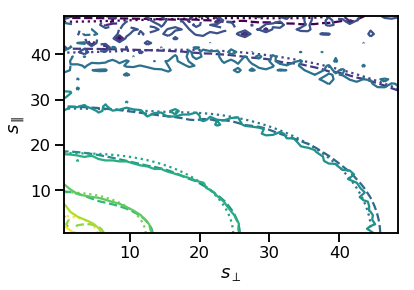

In [124]:
levels = np.linspace(-4. ,1., 10)


plt.contour(rm.s_c, rm.s_c, np.log10(fo).T,
            levels = levels, linestyles = 'dotted')

plt.contour(rm.s_c, rm.s_c, np.log10(so).T,
            levels = levels, linestyles = 'dashed')


plt.contour(rm.s_c, rm.s_c, np.log10(rm.pi_sigma.mean.T),
           levels = levels)

plt.xlabel(r'$s_\perp$')
plt.ylabel(r'$s_\parallel$')

Text(0,0.5,'$s_\\parallel$')

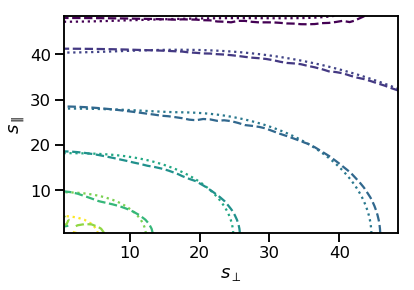

In [132]:
plt.contour(rm.s_c, rm.s_c, np.log10(fo).T,
            levels = levels, linestyles = 'dotted')

plt.contour(rm.s_c, rm.s_c, np.log10(so).T,
            levels = levels, linestyles = 'dashed')



plt.xlabel(r'$s_\perp$')
plt.ylabel(r'$s_\parallel$')

In [125]:
def m3_pi_sigma(sparal, sperp, popt_m_r, popt_c_r, popt_c_t, popt_c3_r, popt_c3_t):

        
    s = np.sqrt(sperp.reshape(-1, 1)**2 + sparal.reshape(1, -1)**2)
    mu = sparal / s
    
    return c3(s, mu, ex.moment(3,0), ex.moment(1,2))\
            + 3 * m1_pi_sigma(sparal, sperp, popt_m_r) * m2_pi_sigma(sparal, sperp, popt_m_r, popt_c_r, popt_c_t) + \
            - 2 * m1_pi_sigma(sparal, sperp, popt_m_r) **3

In [126]:
def third_order(sperp, sparal, xi_spl,  popt_m_r, popt_c_r, popt_c_t, popt_c3_r, popt_c3_t):

    

    return second_order(sperp, sparal, xi_spl,  popt_m_r, popt_c_r, popt_c_t)  \
      - 1. / math.factorial(3) * derivative(m3_pi_sigma, sperp, n = 3, args = (sperp,  popt_m_r, popt_c_r, popt_c_t,
                                                                    popt_c3_r, popt_c3_t) )


In [127]:
to = third_order(rm.s_c, rm.s_c, xi_spl, popt_m_r, popt_c_r, popt_c_t, popt_c3_r, popt_c3_t)

Text(0,0.5,'$s_\\parallel$')

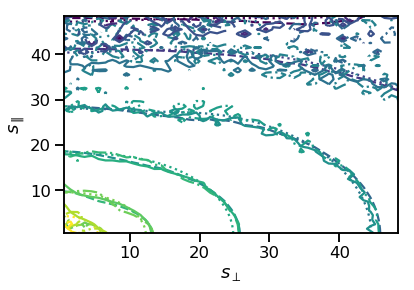

In [133]:
levels = np.linspace(-4. ,1., 10)


plt.contour(rm.s_c, rm.s_c, np.log10(fo).T,
            levels = levels, linestyles = 'dotted')

plt.contour(rm.s_c, rm.s_c, np.log10(so).T,
            levels = levels, linestyles = 'dashed')


plt.contour(rm.s_c, rm.s_c, np.log10(to).T,
            levels = levels, linestyles = '-.')

plt.contour(rm.s_c, rm.s_c, np.log10(rm.pi_sigma.mean.T),
            levels = levels)

plt.xlabel(r'$s_\perp$')
plt.ylabel(r'$s_\parallel$')

Text(0,0.5,'$s_\\parallel$')

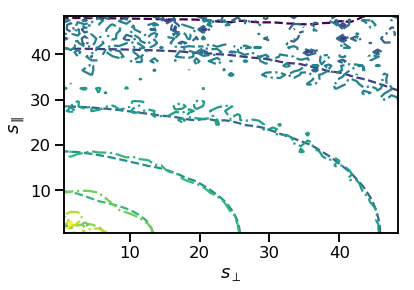

In [134]:
plt.contour(rm.s_c, rm.s_c, np.log10(so).T,
            levels = levels, linestyles = 'dashed')


plt.contour(rm.s_c, rm.s_c, np.log10(to).T,
            levels = levels, linestyles = '-.')

plt.xlabel(r'$s_\perp$')
plt.ylabel(r'$s_\parallel$')